In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Idea: Women are less likely than men to take long trips, like across boroughs (sadly borough is not in the data, and geocoding is probably outside the scope of this assignment).

##### *Null Hypothesis:* The proportion of trips taken by women riders that are more than 15 minutes in duration is the same or higher than the proportion of trips taken by men riders that are more than 15 minutes in duration.

##### *Alternative Hypothesis:* The proportion of trips taken by women riders are more than 15 minutes in duration is less than the proportion of trips taken by men riders that are more than 15 minutes in duration.

##### *Confidence Level:* I will use a significance level $\\alpha=0.05$

#### Null Hypothesis Formula

$$\frac{\textrm{Women Rider > 15m Duration}}{\textrm{Women Rider All Trips}} - \frac{\textrm{Male Rider > 15m Duration}}{\textrm{Male Rider All Trips}} >= 0$$

#### Alternative Hypothesis Formula

$$\frac{\textrm{Women Rider > 15m Duration}}{\textrm{Women Rider All Trips}} - \frac{\textrm{Male Rider > 15m Duration}}{\textrm{Male Rider All Trips}} < 0$$

##### *Data:* I will use three months' worth of Citibike data from March 2015 to May 2015

In [2]:
os.environ["PUIDATA"] = "%s/PUIData"%os.getenv("HOME")

In [3]:
os.chdir(os.getenv("PUIDATA"))

In [4]:
os.getcwd()

'/nfshome/mrn291/PUIData'

In [5]:
# Read in Data from Citibike Website
march_url = 'https://s3.amazonaws.com/tripdata/201503-citibike-tripdata.zip'
april_url = 'https://s3.amazonaws.com/tripdata/201504-citibike-tripdata.zip'
may_url = 'https://s3.amazonaws.com/tripdata/201505-citibike-tripdata.zip'

In [6]:
url_set = [march_url, april_url, may_url]

In [7]:
for url in url_set:
    if os.path.isfile(os.getenv("PUIDATA") + "/" + url[-28:]):
        print("Data already there!")
    else:
        os.system("curl -O " + url)
        os.system("unzip " + os.getenv("PUIDATA") + "/" + url[-28:])

Data already there!
Data already there!
Data already there!


In [8]:
march_data = pd.read_csv('201503-citibike-tripdata.csv')

In [9]:
april_data = pd.read_csv('201504-citibike-tripdata.csv')

In [10]:
may_data = pd.read_csv('201505-citibike-tripdata.csv')

In [11]:
#concatenate the three dataframes together into one.
frames = [march_data, april_data, may_data]

citibike_data = pd.concat(frames, ignore_index=True)

In [12]:
citibike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,669,3/1/2015 0:00,3/1/2015 0:11,164,E 47 St & 2 Ave,40.753231,-73.970325,477,W 41 St & 8 Ave,40.756405,-73.990026,21409,Subscriber,1987.0,1
1,750,3/1/2015 0:01,3/1/2015 0:14,258,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,436,Hancock St & Bedford Ave,40.682166,-73.953990,19397,Subscriber,1968.0,1
2,663,3/1/2015 0:01,3/1/2015 0:12,497,E 17 St & Broadway,40.737050,-73.990093,477,W 41 St & 8 Ave,40.756405,-73.990026,20998,Customer,NaN,0
3,480,3/1/2015 0:02,3/1/2015 0:10,470,W 20 St & 8 Ave,40.743453,-74.000040,491,E 24 St & Park Ave S,40.740964,-73.986022,21565,Subscriber,1983.0,1
4,1258,3/1/2015 0:02,3/1/2015 0:23,345,W 13 St & 6 Ave,40.736494,-73.997044,473,Rivington St & Chrystie St,40.721101,-73.991925,14693,Subscriber,1970.0,1


In [13]:
# make a subset that is just the variables of interest
# note that gender coded as 0=unknown; 1=male; 2=female
variables = ['tripduration','gender']

citibike_subset = citibike_data.loc[:, citibike_data.columns.isin(variables)].copy()
citibike_subset['long_trip'] = np.where(citibike_subset['tripduration']>900, 1,0)

In [14]:
citibike_subset.head()

,tripduration,gender,long_trip
0,669,1,0
1,750,1,0
2,663,0,0
3,480,1,0
4,1258,1,1


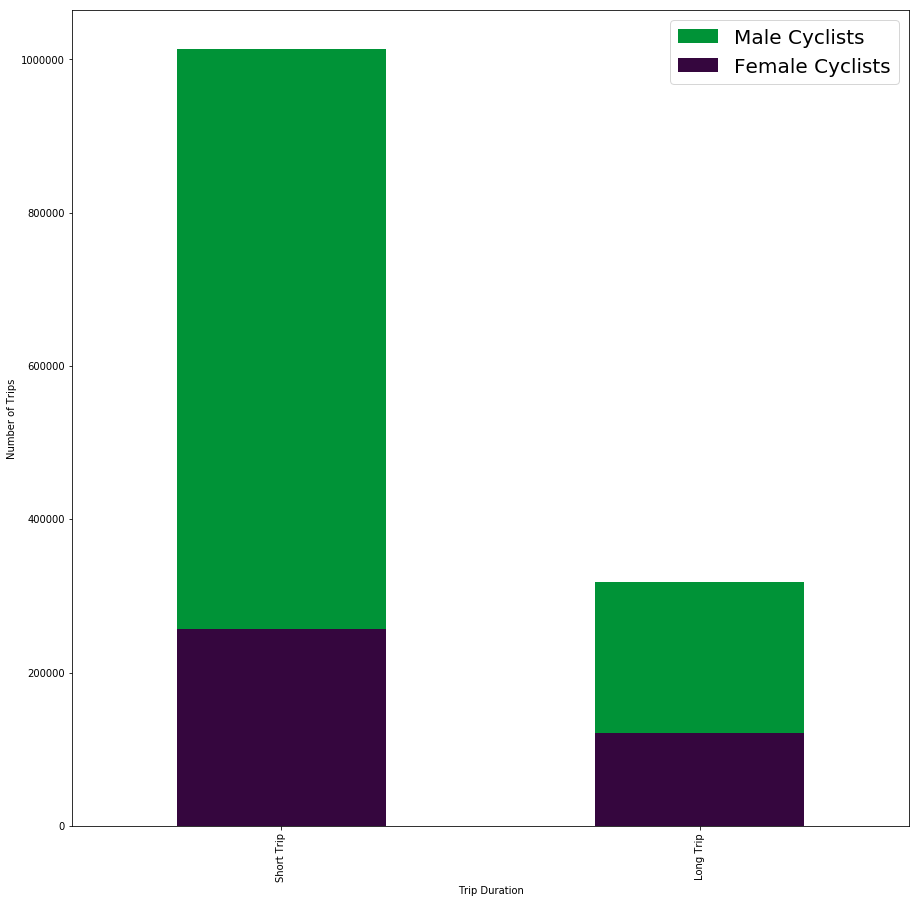

In [15]:
#plot the variables of interest
fig = pl.figure(figsize(15,15))

#filter out unknown
plot_data = pd.pivot_table(citibike_subset[citibike_subset['gender'] >0], index='long_trip', columns='gender', aggfunc='count')
plot_data.columns = ['male','female']

plot_data['male'].plot(kind="bar", color='xkcd:kelley green', label='male')
plot_data['female'].plot(kind="bar", color='xkcd:dark purple', label='female') 
plt.xlabel("Trip Duration")
plt.ylabel("Number of Trips")
plt.xticks(np.arange(2), ('Short Trip','Long Trip'))
plt.legend(['Male Cyclists', 'Female Cyclists'], fontsize=20)

*Figure showing the relative number of short (<= 15 minutes) versus long (> 15 minutes) Citibike trips by gender from March 2015 to May 2015*

### Apply Statistical Test

My reviewer suggested a chi-square test.  However, given the way the hypothesis was formulated, I think the more appropriate test is the t-test for independent proportions, since technically what I am interested in is the size of the difference between two proportions, and not just whether or not there is a significant difference.

A chi-square should lead one to the same conclusion and it wasn't a bad idea.  I'll do both and compare.

I will use a significance level $\\alpha=0.05$

In [16]:
#filter down to just observations with gender
# note that gender coded as 0=unknown; 1=male; 2=female
test_data = citibike_subset[citibike_subset['gender'] >0]
test_data.head()

,tripduration,gender,long_trip
0,669,1,0
1,750,1,0
3,480,1,0
4,1258,1,1
5,363,1,0


In [17]:
#set up table
contingency_table = test_data.pivot_table(index='gender', columns='long_trip', aggfunc='count')

In [18]:
contingency_table.head()

tripduration        
long_trip            0       1
gender                        
1              1013105  318336
2               256190  121397

##### Chi Square Test of Independence

In [19]:
obs = np.array([contingency_table.iloc[0], contingency_table.iloc[1]])

In [20]:
chi2, p, dof, ex = stats.chi2_contingency(obs)

In [21]:
print("The chi-square value is %f and the alpha is %f with %i degree of freedom"%(chi2, p, dof))

The chi-square value is 10455.432109 and the alpha is 0.000000 with 1 degree of freedom


Given the extremely large size of the chi-sqaure statistic and the alpha of 0, we can reject a null hypothesis that there is no association between gender and long/short trips.

##### t-test for Independent Proportions

In [22]:
contingency_table.columns = contingency_table.columns.droplevel(0)

In [23]:
w_ride_prop = contingency_table.iloc[1][1] / contingency_table.iloc[1].sum()
m_ride_prop = contingency_table.iloc[0][1] / contingency_table.iloc[0].sum()
w_n = contingency_table.iloc[1].sum()
m_n = contingency_table.iloc[0].sum()

w_ride_data = np.array(test_data[test_data['gender'] == 2].long_trip)
m_ride_data = np.array(test_data[test_data['gender'] == 1].long_trip)

print("The proportion of trips by women riders that are longer than 15 minutes is %f"%w_ride_prop)
print("The proportion of trips by male riders that are longer than 15 minutes is %f"%m_ride_prop)

The proportion of trips by women riders that are longer than 15 minutes is 0.321507
The proportion of trips by male riders that are longer than 15 minutes is 0.239091


In [24]:
statistic, p = stats.ttest_ind(w_ride_data, m_ride_data)

In [25]:
print("The t-statistic is %f and the alpha is %f"%(statistic, p))

The t-statistic is 102.568094 and the alpha is 0.000000


In [28]:
sd = np.sqrt(np.sum(np.power(w_ride_data - w_ride_data.mean(),2)) / (w_ride_data.size - 1))
sd

0.46705562369392511

In [29]:
alpha = 0.05
interval = stats.t.ppf(1.0 - (alpha / 2.0), w_ride_data.size-1) * (sd / np.sqrt(w_ride_data.size))
ci = (w_ride_data.mean() - interval, w_ride_data.mean() + interval)
ci

(0.32001762432788144, 0.32299709810694816)